In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
#test_dataset = datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms.ToTensor(), )
#train_dataset.data = transforms(torch.from_numpy(train_dataset.data))
#train_dataset.targets = torch.tensor(train_dataset.targets)
#test_dataset.data = torch.tensor(test_dataset.data)
#test_dataset.targets = torch.tensor(test_dataset.targets)

image, label = train_dataset[0]

torch.max(image), torch.min(image)

Files already downloaded and verified


(tensor(1.), tensor(-1.))

torch.Size([3, 32, 32])
9


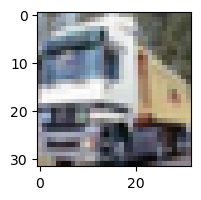

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = train_dataset[1]
print(image.shape)
print(label)

# (c, h, w) -> (h, w, c)
image = image.permute(1, 2, 0)
image = (image + 1) / 2
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

In [3]:
from models.inheritance import Unet

bs = 32
ch = 3
size = 32
timestep = 5000
down_chs = (64, 256, 256, 256)
lr = 2e-4
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(
    ch=ch,
    size=size,
    down_chs=down_chs,
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    timestep=timestep,
).to(device)

device

/root/anaconda3/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [4]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

32142851

In [5]:
def sample_image(image):
    image = image.squeeze(0).cpu()
        
    # (c, h, w) -> (h, w, c)
    image = image.permute(1, 2, 0)
    
    # [-1, 1] -> [0, 1]
    image = (image + 1) / 2
    image = torch.clip(image, 0, 1)

    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.show()

In [6]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm


train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
optimizer = Adam(model.parameters(), lr=lr)

Epoch 0 | step: 1562 | loss: 0.0235: 100%|██████████| 1563/1563 [02:26<00:00, 10.65it/s]
Sampling...: 100%|██████████| 5000/5000 [01:31<00:00, 54.40it/s]


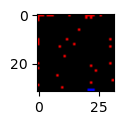

Epoch 1 | step: 1562 | loss: 0.0453: 100%|██████████| 1563/1563 [02:30<00:00, 10.39it/s]
Sampling...: 100%|██████████| 5000/5000 [01:23<00:00, 60.20it/s]


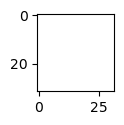

Epoch 2 | step: 1562 | loss: 0.0087: 100%|██████████| 1563/1563 [02:31<00:00, 10.31it/s]
Sampling...: 100%|██████████| 5000/5000 [01:21<00:00, 61.68it/s]


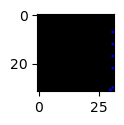

Epoch 3 | step: 1562 | loss: 0.0029: 100%|██████████| 1563/1563 [02:30<00:00, 10.39it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.13it/s]


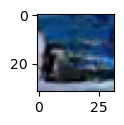

Epoch 4 | step: 1562 | loss: 0.0100: 100%|██████████| 1563/1563 [02:29<00:00, 10.46it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 61.87it/s]


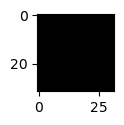

Epoch 5 | step: 1562 | loss: 0.0096: 100%|██████████| 1563/1563 [02:28<00:00, 10.51it/s]
Sampling...: 100%|██████████| 5000/5000 [01:21<00:00, 61.08it/s]


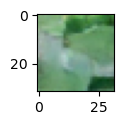

Epoch 6 | step: 1562 | loss: 0.0244: 100%|██████████| 1563/1563 [02:29<00:00, 10.49it/s]
Sampling...: 100%|██████████| 5000/5000 [01:21<00:00, 61.09it/s]


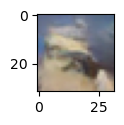

Epoch 7 | step: 1562 | loss: 0.0053: 100%|██████████| 1563/1563 [02:27<00:00, 10.60it/s]
Sampling...: 100%|██████████| 5000/5000 [01:27<00:00, 56.92it/s]


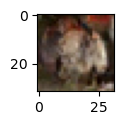

Epoch 8 | step: 1562 | loss: 0.0104: 100%|██████████| 1563/1563 [02:29<00:00, 10.48it/s]
Sampling...: 100%|██████████| 5000/5000 [01:22<00:00, 60.66it/s]


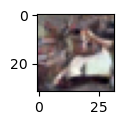

Epoch 9 | step: 1562 | loss: 0.0071: 100%|██████████| 1563/1563 [02:29<00:00, 10.48it/s]
Sampling...: 100%|██████████| 5000/5000 [01:31<00:00, 54.71it/s]


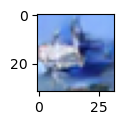

Epoch 10 | step: 1562 | loss: 0.0143: 100%|██████████| 1563/1563 [02:31<00:00, 10.31it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 61.74it/s]


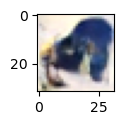

Epoch 11 | step: 1562 | loss: 0.0029: 100%|██████████| 1563/1563 [02:34<00:00, 10.12it/s]
Sampling...: 100%|██████████| 5000/5000 [01:23<00:00, 60.02it/s]


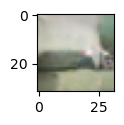

Epoch 12 | step: 1562 | loss: 0.0103: 100%|██████████| 1563/1563 [02:31<00:00, 10.33it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 61.85it/s]


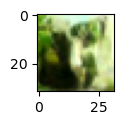

Epoch 13 | step: 1562 | loss: 0.0141: 100%|██████████| 1563/1563 [02:30<00:00, 10.38it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.11it/s]


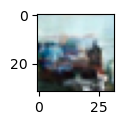

Epoch 14 | step: 1562 | loss: 0.0017: 100%|██████████| 1563/1563 [02:29<00:00, 10.44it/s]
Sampling...: 100%|██████████| 5000/5000 [01:21<00:00, 61.26it/s]


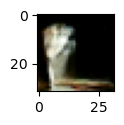

Epoch 15 | step: 1562 | loss: 0.0181: 100%|██████████| 1563/1563 [02:29<00:00, 10.47it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.10it/s]


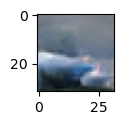

Epoch 16 | step: 1562 | loss: 0.0122: 100%|██████████| 1563/1563 [02:27<00:00, 10.61it/s]
Sampling...: 100%|██████████| 5000/5000 [01:28<00:00, 56.53it/s]


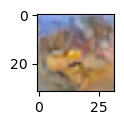

Epoch 17 | step: 1562 | loss: 0.0276: 100%|██████████| 1563/1563 [02:28<00:00, 10.50it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 61.74it/s]


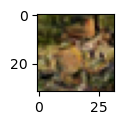

Epoch 18 | step: 1562 | loss: 0.0060: 100%|██████████| 1563/1563 [02:27<00:00, 10.57it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.10it/s]


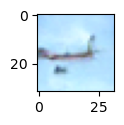

Epoch 19 | step: 1562 | loss: 0.0136: 100%|██████████| 1563/1563 [02:25<00:00, 10.71it/s]
Sampling...: 100%|██████████| 5000/5000 [01:26<00:00, 57.92it/s]


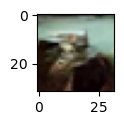

Epoch 20 | step: 1562 | loss: 0.0017: 100%|██████████| 1563/1563 [02:29<00:00, 10.46it/s]
Sampling...: 100%|██████████| 5000/5000 [01:33<00:00, 53.64it/s]


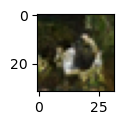

Epoch 21 | step: 1562 | loss: 0.0028: 100%|██████████| 1563/1563 [02:32<00:00, 10.25it/s]
Sampling...: 100%|██████████| 5000/5000 [01:23<00:00, 59.89it/s]


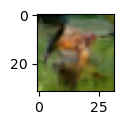

Epoch 22 | step: 1562 | loss: 0.0096: 100%|██████████| 1563/1563 [02:32<00:00, 10.22it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.38it/s]


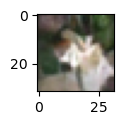

Epoch 23 | step: 1562 | loss: 0.0075: 100%|██████████| 1563/1563 [01:53<00:00, 13.74it/s]
Sampling...: 100%|██████████| 5000/5000 [01:17<00:00, 64.12it/s]


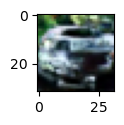

Epoch 24 | step: 1562 | loss: 0.0134: 100%|██████████| 1563/1563 [01:44<00:00, 14.91it/s]
Sampling...: 100%|██████████| 5000/5000 [01:29<00:00, 55.94it/s]


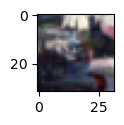

Epoch 25 | step: 1562 | loss: 0.0020: 100%|██████████| 1563/1563 [01:44<00:00, 14.91it/s]
Sampling...: 100%|██████████| 5000/5000 [01:22<00:00, 60.51it/s]


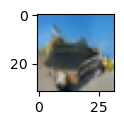

Epoch 26 | step: 1562 | loss: 0.0079: 100%|██████████| 1563/1563 [01:44<00:00, 15.01it/s]
Sampling...: 100%|██████████| 5000/5000 [01:26<00:00, 57.55it/s]


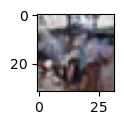

Epoch 27 | step: 1562 | loss: 0.0085: 100%|██████████| 1563/1563 [01:47<00:00, 14.50it/s]
Sampling...: 100%|██████████| 5000/5000 [01:23<00:00, 59.71it/s]


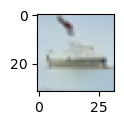

Epoch 28 | step: 1562 | loss: 0.0015: 100%|██████████| 1563/1563 [01:53<00:00, 13.79it/s]
Sampling...: 100%|██████████| 5000/5000 [01:22<00:00, 60.73it/s]


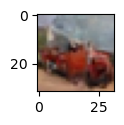

Epoch 29 | step: 1562 | loss: 0.0097: 100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]
Sampling...: 100%|██████████| 5000/5000 [01:24<00:00, 59.07it/s]


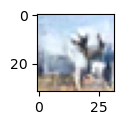

Epoch 30 | step: 1562 | loss: 0.0128: 100%|██████████| 1563/1563 [01:56<00:00, 13.40it/s]
Sampling...: 100%|██████████| 5000/5000 [01:25<00:00, 58.35it/s]


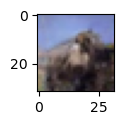

Epoch 31 | step: 1562 | loss: 0.0131: 100%|██████████| 1563/1563 [01:46<00:00, 14.63it/s]
Sampling...: 100%|██████████| 5000/5000 [01:17<00:00, 64.85it/s]


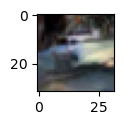

Epoch 32 | step: 1562 | loss: 0.0164: 100%|██████████| 1563/1563 [01:45<00:00, 14.83it/s]
Sampling...: 100%|██████████| 5000/5000 [01:18<00:00, 63.89it/s]


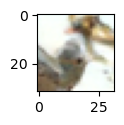

Epoch 33 | step: 1562 | loss: 0.0088: 100%|██████████| 1563/1563 [01:46<00:00, 14.70it/s]
Sampling...: 100%|██████████| 5000/5000 [01:19<00:00, 63.17it/s]


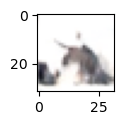

Epoch 34 | step: 1562 | loss: 0.0175: 100%|██████████| 1563/1563 [01:49<00:00, 14.23it/s]
Sampling...: 100%|██████████| 5000/5000 [01:17<00:00, 64.34it/s]


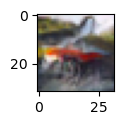

Epoch 35 | step: 1562 | loss: 0.0054: 100%|██████████| 1563/1563 [01:44<00:00, 14.97it/s]
Sampling...: 100%|██████████| 5000/5000 [01:18<00:00, 63.84it/s]


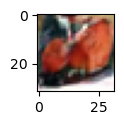

Epoch 36 | step: 1562 | loss: 0.0124: 100%|██████████| 1563/1563 [01:52<00:00, 13.94it/s]
Sampling...: 100%|██████████| 5000/5000 [01:23<00:00, 59.91it/s]


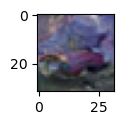

Epoch 37 | step: 1562 | loss: 0.0016: 100%|██████████| 1563/1563 [01:47<00:00, 14.52it/s]
Sampling...: 100%|██████████| 5000/5000 [01:21<00:00, 60.98it/s]


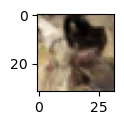

Epoch 38 | step: 1562 | loss: 0.0123: 100%|██████████| 1563/1563 [01:55<00:00, 13.51it/s]
Sampling...: 100%|██████████| 5000/5000 [01:16<00:00, 65.56it/s]


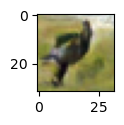

Epoch 39 | step: 1562 | loss: 0.0035: 100%|██████████| 1563/1563 [01:43<00:00, 15.03it/s]
Sampling...: 100%|██████████| 5000/5000 [01:27<00:00, 56.88it/s]


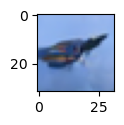

Epoch 40 | step: 1562 | loss: 0.0214: 100%|██████████| 1563/1563 [01:45<00:00, 14.81it/s]
Sampling...: 100%|██████████| 5000/5000 [01:18<00:00, 63.75it/s]


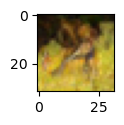

Epoch 41 | step: 1562 | loss: 0.0078: 100%|██████████| 1563/1563 [01:47<00:00, 14.61it/s]
Sampling...: 100%|██████████| 5000/5000 [01:29<00:00, 55.57it/s]


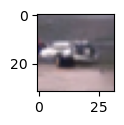

Epoch 42 | step: 1562 | loss: 0.0021: 100%|██████████| 1563/1563 [01:52<00:00, 13.87it/s]
Sampling...: 100%|██████████| 5000/5000 [01:22<00:00, 60.53it/s]


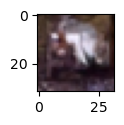

Epoch 43 | step: 1562 | loss: 0.0025: 100%|██████████| 1563/1563 [01:49<00:00, 14.24it/s]
Sampling...: 100%|██████████| 5000/5000 [01:22<00:00, 60.62it/s]


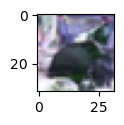

Epoch 44 | step: 1562 | loss: 0.0034: 100%|██████████| 1563/1563 [01:49<00:00, 14.24it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.25it/s]


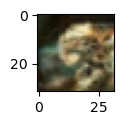

Epoch 45 | step: 1562 | loss: 0.0175: 100%|██████████| 1563/1563 [01:48<00:00, 14.46it/s]
Sampling...: 100%|██████████| 5000/5000 [01:20<00:00, 62.01it/s]


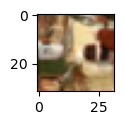

Epoch 46 | step: 1562 | loss: 0.0084: 100%|██████████| 1563/1563 [01:48<00:00, 14.43it/s]
Sampling...: 100%|██████████| 5000/5000 [01:34<00:00, 52.94it/s]


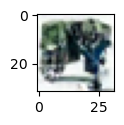

Epoch 47 | step: 1562 | loss: 0.0033: 100%|██████████| 1563/1563 [01:48<00:00, 14.34it/s]
Sampling...: 100%|██████████| 5000/5000 [01:25<00:00, 58.28it/s]


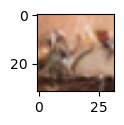

Epoch 48 | step: 1562 | loss: 0.0226: 100%|██████████| 1563/1563 [01:45<00:00, 14.76it/s]
Sampling...: 100%|██████████| 5000/5000 [01:17<00:00, 64.17it/s]


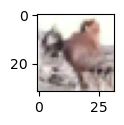

Epoch 49 | step: 1562 | loss: 0.0098: 100%|██████████| 1563/1563 [01:47<00:00, 14.58it/s]
Sampling...: 100%|██████████| 5000/5000 [01:25<00:00, 58.53it/s]


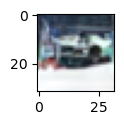

In [7]:
model.train()
samples = []

for epoch in range(epochs):
    loader = tqdm(train_loader)
    
    for step, batch in enumerate(loader):
        image, label = batch
        
        bs_dim = image.shape[0]
        
        image = image.to(device)
        t = torch.randint(0, timestep, (bs_dim, ), device=device)
        
        optimizer.zero_grad()
        
        loss = model.get_loss(image, t)
        
        loss.backward()
        
        optimizer.step()

        loader.set_description(f'Epoch {epoch} | step: {step} | loss: {loss.item():.4f}')
    
    with torch.no_grad():
        sample = model.sampling(size=(1, ch, size, size))
        samples.append(sample)
        sample_image(sample)

Sampling...:   0%|          | 0/5000 [00:00<?, ?it/s]

Sampling...: 100%|██████████| 5000/5000 [01:19<00:00, 63.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 32, 3])


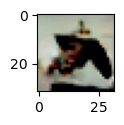

In [9]:
model.eval()

with torch.no_grad():
    image = model.sampling(size=(1, ch, size, size))
    image = image.squeeze(0).cpu()
    # (bs, h, w, c) -> (bs, c, h, w)
    image = image.permute(1, 2, 0)

    print(image.shape)
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.show()

In [10]:
# save ckpt
SAVE_MODE = True
PATH = 'ckpt/CIFAR10.pt'

if SAVE_MODE:
    torch.save(model.state_dict(), PATH)